Maximum likelihood estimates:
Companion mass = 0.00136
Companion period = 99.50061
Companion eccentricity = 0.00249
Companion inclination = 88.77947
Companion longnode = 0.00084
Companion argument = 0.00068
Companion mean anomaly = 210.91108
f = 0.00006


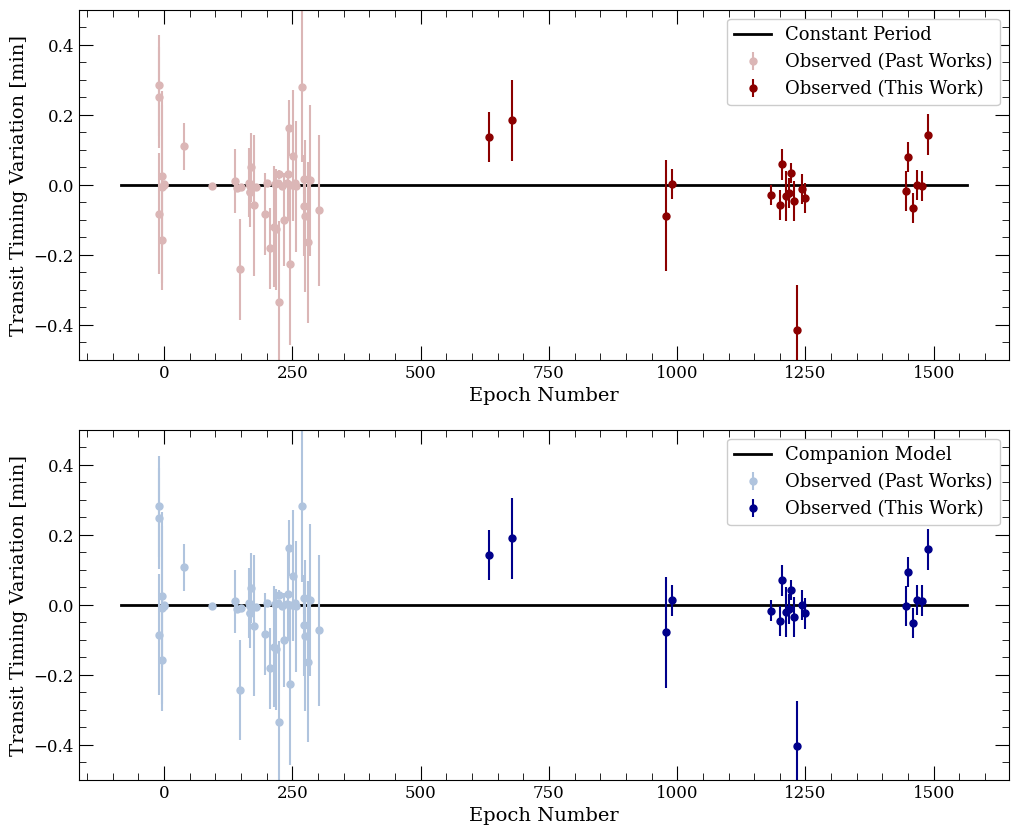

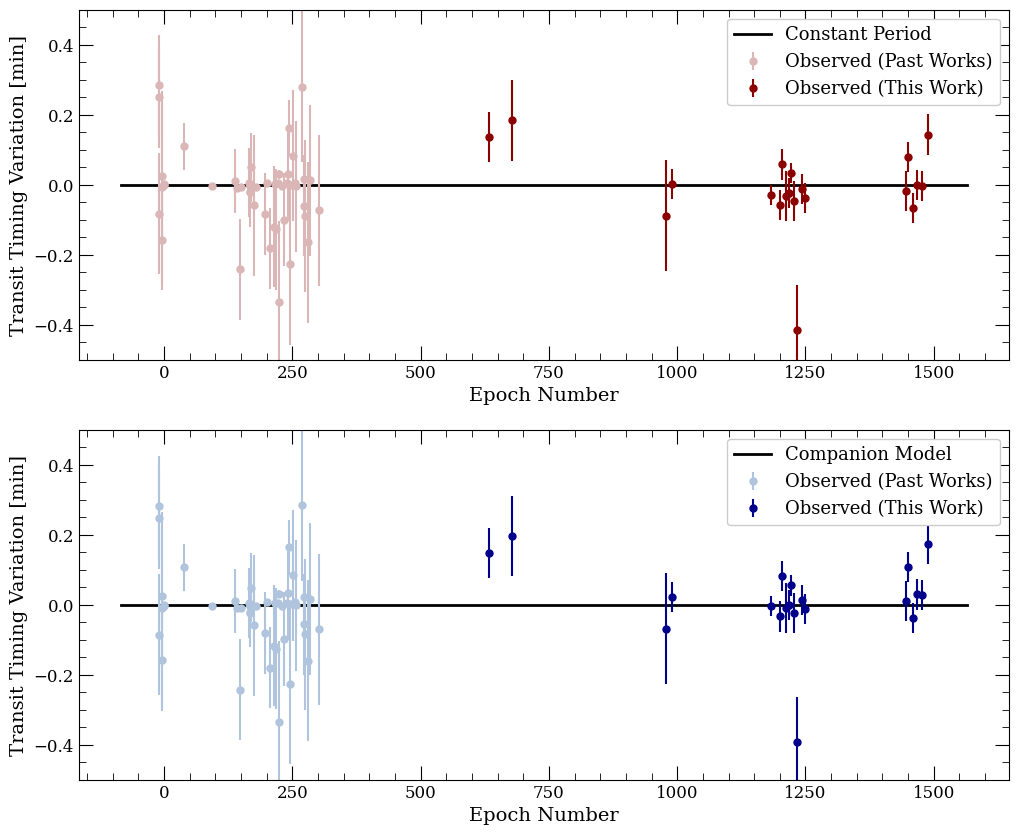

In [12]:
import numpy as np
import pandas as pd
import os
import dynesty

import matplotlib.pyplot as plt
import corner

import argparse
import yaml

from scipy.optimize import minimize
from IPython.display import Math

import ttvfast
from utils import *
from utils_plot import *


# initial guesses
p2_mass_init = 0.000896 # solar masses
p2_period_init = 99.5 # days
p2_eccentricity_init = 0
p2_inclination_init = 88.778
p2_mean_anomaly_init = 210.91
p2_argument_init = 0
p2_longnode_init = 0
log_f_init = np.log(0.01)
theta_initial = np.array([p2_mass_init, p2_period_init, p2_eccentricity_init, p2_inclination_init, p2_longnode_init, p2_argument_init, p2_mean_anomaly_init, log_f_init])

# get config file
with open('config.yml', 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

# get observed transit times
ref_transit = config['ref_transit']
filepath = config['transit_times_filepath']
df = pd.read_csv(filepath)
t_obs = df['T_mid'].to_numpy()
t_obs_err = df['Uncertainty (days)'].to_numpy()

savepath = config['savepath']

# read physical parameters and integration parameters from config
G = config['G']
stellar_mass = config['stellar_mass']
time_step = config['time_step']
start_epoch = config['start_epoch']
duration = config['duration']

# WD 1856+534 b
p1_mass = config['p1_mass']
p1_period = config['p1_period']
p1_eccentricity = config['p1_eccentricity']
p1_inclination = config['p1_inclination']
p1_longnode = config['p1_longnode']
p1_argument = config['p1_argument']
p1_mean_anomaly = config['p1_mean_anomaly']

planet1 = ttvfast.models.Planet(
    mass = p1_mass,
    period = p1_period,
    eccentricity = p1_eccentricity,
    inclination = p1_inclination,
    longnode = p1_longnode,
    argument = p1_argument,
    mean_anomaly = p1_mean_anomaly
)

def get_epoch(midtransit):
    period = p1_period
    epoch = np.around((midtransit - ref_transit) / period)
    return epoch

epochs_obs = get_epoch(t_obs)

def get_transit_time_predictions(theta):
    p2_mass, p2_period, p2_eccentricity, p2_inclination, p2_longnode, \
    p2_argument, p2_mean_anomaly = theta
    planet2 = ttvfast.models.Planet(
        mass = p2_mass,
        period = p2_period,
        eccentricity = p2_eccentricity,
        inclination = p2_inclination,
        longnode = p2_longnode,
        argument = p2_argument,
        mean_anomaly = p2_mean_anomaly
    )

    planets = [planet1, planet2]
    start_time = ref_transit + start_epoch * p1_period
    end_time = start_time + duration
    results = ttvfast.ttvfast(planets, stellar_mass, start_time, time_step, end_time)
    planet_id = np.array(results['positions'][0])
    transit_times = np.array(results['positions'][2])
    mask = np.logical_and(planet_id == 0, transit_times >= 0)
    return transit_times[mask]

t_pred = get_transit_time_predictions(theta_initial[:-1])
epochs_pred = get_epoch(t_pred)

t_p = []
for epoch in epochs_obs:
    idx = np.where(epochs_pred == epoch)[0]
    if idx.size != 0:
        t_p.append(t_pred[idx[0]])
t_p = np.array(t_p)
R = romer_delay(p1_period, p2_period_init, p1_mass, p2_mass_init, stellar_mass, p1_inclination, ref_transit, t_p)
t_p += R

ref_idx = np.where(epochs_obs==get_epoch(ref_transit))[0][0]
offset = t_obs[ref_idx] - t_p[ref_idx]
t_p += offset

# plot initial O-C curve
savepath = 'mcmc_plots/initial_o-c.pdf'
plot_transit_times(t_obs, epochs_obs, t_p, get_epoch(t_p), t_obs_err, savepath)

# likelihood function for Gaussian distribution with variance underestimated by fractional amount f
def log_likelihood(theta): # x = epoch, y = o-c
    y = t_obs
    yerr = t_obs_err
    log_f = theta[-1]
    t_pred = get_transit_time_predictions(theta[:-1])
    epochs_pred = get_epoch(t_pred)

    t_p = []
    for epoch in epochs_obs:
        idx = np.where(epochs_pred == epoch)[0]
        if idx.size != 0:
            t_p.append(t_pred[idx[0]])
    t_p = np.array(t_p)
    R = romer_delay(p1_period, theta[1], p1_mass, theta[0], stellar_mass, p1_inclination, ref_transit, t_p)
    t_p += R

    ref_idx = np.where(epochs_obs==get_epoch(ref_transit))[0][0]
    offset = t_obs[ref_idx] - t_p[ref_idx]
    t_p += offset

    model = t_p
    sigma2 = yerr**2 + np.exp(2*log_f) #yerr**2 + model**2 * np.exp(2*log_f)
    if y.shape != model.shape:
        return -np.inf
    else:
        return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

# negative log likelihood function
nll = lambda arg: -log_likelihood(arg)

# maximum likelihood solution with plot (if feasible)
soln = minimize(nll, theta_initial)
theta_ml = soln.x
p2_mass_ml, p2_period_ml, p2_eccentricity_ml, p2_inclination_ml, p2_longnode_ml, \
    p2_argument_ml, p2_mean_anomaly_ml, log_f_ml = theta_ml

print("Maximum likelihood estimates:")
print("Companion mass = {0:.5f}".format(p2_mass_ml))
print("Companion period = {0:.5f}".format(p2_period_ml))
print("Companion eccentricity = {0:.5f}".format(p2_eccentricity_ml))
print("Companion inclination = {0:.5f}".format(p2_inclination_ml))
print("Companion longnode = {0:.5f}".format(p2_longnode_ml))
print("Companion argument = {0:.5f}".format(p2_argument_ml))
print("Companion mean anomaly = {0:.5f}".format(p2_mean_anomaly_ml))
print("f = {0:.5f}".format(np.exp(log_f_ml)))

t_pred = get_transit_time_predictions(theta_ml[:-1])
epochs_pred = get_epoch(t_pred)

t_p = []
for epoch in epochs_obs:
    idx = np.where(epochs_pred == epoch)[0]
    if idx.size != 0:
        t_p.append(t_pred[idx[0]])
t_p = np.array(t_p)
R = romer_delay(p1_period, theta_ml[1], p1_mass, theta_ml[0], stellar_mass, p1_inclination, ref_transit, t_p)
t_p += R

ref_idx = np.where(epochs_obs==get_epoch(ref_transit))[0][0]
offset = t_obs[ref_idx] - t_p[ref_idx]
t_p += offset

savepath = 'mcmc_plots/ml_o-c.pdf'
plot_transit_times(t_obs, epochs_obs, t_p, get_epoch(t_p), t_obs_err, savepath)

# define uniform priors on all parameters
def uniform_prior(theta):
    p2_mass, p2_period, p2_eccentricity, p2_inclination, p2_longnode, \
    p2_argument, p2_mean_anomaly, log_f = theta
    if (0.000003 < p2_mass < 0.0124 and 50 < p2_period < 1500 and 0 < p2_eccentricity < 1 and \
        0 < p2_inclination < 90 and 0 < p2_longnode < 360 and 0 < p2_argument < 360 and \
        0 < p2_mean_anomaly < 360 and -10 < log_f < 10):
        return 0.0
    return -np.inf

# define log probability
def log_probability(theta, x, y, yerr): # x = epoch, y = o-c
    lp = uniform_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [14]:
ndim = 8
dsampler = dynesty.DynamicNestedSampler(log_likelihood, uniform_prior, ndim)
dsampler.run_nested()
dresults = dsampler.results

0it [00:00, ?it/s]Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/dynesty/dynesty.py", line 913, in __call__
    return self.func(np.asarray(x).copy(), *self.args, **self.kwargs)
           ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/sr/g5sjm4bd55nbc1x4wnqb1dqw0000gn/T/ipykernel_50763/3760872146.py", line 123, in log_likelihood
    log_f = theta[-1]
            ~~~~~^^^^
IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed
0it [00:00, ?it/s]

Exception while calling loglikelihood function:
  params: -inf
  args: []
  kwargs: {}
  exception:


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed